In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif,f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn import tree
import dtreeviz
np.set_printoptions(threshold=np.inf)
pd.option_context('display.max_rows', None, 'display.max_columns', None)

In [2]:
radiomic_features_df = pd.read_table('Data\clinical_radiomics.tsv')
print(radiomic_features_df)

      ID      MIP     sex  age histopathology   type location  T  N  \
0      1  1842722    MALE   81     Large_Cell  NSCLC    RIGHT  3  0   
1      2   596362    MALE   74       SQUAMOUS  NSCLC     LEFT  2  2   
2      3  1650062    MALE   77       SQUAMOUS  NSCLC     LEFT  2  2   
3      4   701827  FEMALE   74       SQUAMOUS  NSCLC    RIGHT  3  2   
4      5  1811403    MALE   78     Large_Cell  NSCLC    RIGHT  3  0   
..   ...      ...     ...  ...            ...    ...      ... .. ..   
126  127   653575  FEMALE   45          ADENO  NSCLC     LEFT  2  2   
127  128  1373477    MALE   46       SQUAMOUS  NSCLC    RIGHT  4  0   
128  129   707208  FEMALE   43     Large_Cell  NSCLC    RIGHT  2  2   
129  130   749310    MALE   43       SQUAMOUS  NSCLC     LEFT  2  2   
130  131  1826730    MALE   46       SQUAMOUS  NSCLC     LEFT  2  2   

     zubrod_score  ...  original_gldm_LargeDependenceLowGrayLevelEmphasis  \
0             1.0  ...                                          12.813

In [3]:
#Clean up
radiomic_features_df = radiomic_features_df[radiomic_features_df.OS_cens == '0']
radiomic_features_df["OS_result"] = radiomic_features_df["OS"] > 2.15 if 'long' else 'short'
radiomic_features_df = radiomic_features_df.drop(columns=["Image","Mask","type","CT_drugs","Treatment", "intent", "Metastasis_location", 
                                                          "diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy",
                                                          "diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet",
                                                          "diagnostics_Versions_Python","diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes",
                                                          "diagnostics_Image.original_Hash", "diagnostics_Image.original_Dimensionality", "diagnostics_Image.original_Spacing",
                                                          "diagnostics_Image.original_Minimum", "OS_cens","diagnostics_Image.original_Minimum", "OS", "diagnostics_Mask.original_Hash",
                                                          "diagnostics_Mask.original_Spacing", "diagnostics_Mask.original_BoundingBox",	"diagnostics_Mask.original_VoxelNum", "N",
                                                          "diagnostics_Mask.original_Size",  "diagnostics_Image.original_Size", "diagnostics_Mask.original_CenterOfMassIndex",	"diagnostics_Mask.original_CenterOfMass",
                                                          "CT_effect", "zubrod_score", "T", "HT", "PLT", "RBC", "WBC", "ID", "MFS","MFS_cens","CT_cycles", "histopathology", "location",
                                                           "MIP","RT_fractional_dose", "HB"])
#print(radiomic_features_df)
print(radiomic_features_df .isna().sum())

sex                                   0
age                                   0
RT_total_dose                         0
diagnostics_Image.original_Mean       0
diagnostics_Image.original_Maximum    0
                                     ..
original_ngtdm_Coarseness             0
original_ngtdm_Complexity             0
original_ngtdm_Contrast               0
original_ngtdm_Strength               0
OS_result                             0
Length: 112, dtype: int64


1.25724


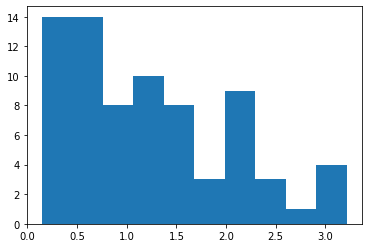

In [23]:
print(radiomic_features_df["OS"].mean())
plt.hist(radiomic_features_df["OS"])
plt.show()

In [8]:
column_names = radiomic_features_df.columns.values.tolist()
comb = combinations(column_names, 5)


In [ ]:
for i in comb:
    print(i)

In [32]:
X = radiomic_features_df.loc[:,radiomic_features_df.columns != "OS_result"]  #independent columns
y = radiomic_features_df.loc[:,radiomic_features_df.columns == "OS_result"]    #target column i.e price range

df1 = pd.get_dummies(X['sex'])
X = pd.concat([X, df1], axis=1).reindex(X.index)
X.drop('sex', axis=1, inplace=True)
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=20)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(25,'Score'))  #print 10 best features

                                              Specs     Score
50                               original_glcm_Imc2  8.915109
20                 original_firstorder_90Percentile  8.721571
25                      original_firstorder_Maximum  8.483177
32              original_firstorder_RootMeanSquared  8.467637
27                         original_firstorder_Mean  8.348890
26        original_firstorder_MeanAbsoluteDeviation  8.059523
28                       original_firstorder_Median  7.936593
30                        original_firstorder_Range  7.665180
31  original_firstorder_RobustMeanAbsoluteDeviation  7.499144
23           original_firstorder_InterquartileRange  7.262999
19                 original_firstorder_10Percentile  7.004891
36                     original_firstorder_Variance  6.868594
49                               original_glcm_Imc1  5.500362
21                       original_firstorder_Energy  4.724026
34                  original_firstorder_TotalEnergy  4.724026
29      

c:\Users\Pc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


C:\Users\Pc\AppData\Local\Temp\ipykernel_11300\1562543965.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[0.00775888 0.00586674 0.01097834 0.00799506 0.         0.02403533
 0.02534403 0.00909898 0.00997338 0.00819907 0.00577664 0.00537419
 0.00554332 0.00751977 0.00964327 0.00865544 0.00943124 0.00676941
 0.00852158 0.01378986 0.0160413  0.00789744 0.01023261 0.01128777
 0.00570119 0.00969681 0.00677192 0.01599818 0.01306795 0.01002872
 0.00803751 0.01365969 0.01533159 0.01185722 0.01217057 0.0086068
 0.00898718 0.00496414 0.00452326 0.02065493 0.00244496 0.02108411
 0.01201216 0.00809235 0.01253581 0.00908949 0.01183311 0.00299533
 0.00605698 0.00912072 0.01271898 0.00869348 0.01076573 0.00605812
 0.00894511 0.00583666 0.01136133 0.00903345 0.02088483 0.00163866
 0.00859275 0.00721494 0.00364073 0.00318628 0.01253523 0.00594025
 0.00478688 0.0121778  0.00490927 0.01263284 0.00824811 0.01273997
 0.00661745 0.00358762 0.00710022 0.00524905 0.00471978 0.00926753
 0.00610788 0.00937001 0.0077223  0.00577737 0.01709261 0.00136087
 0.00896831 0.00813611 0.00673283 0.01483411 0.01017712 0.00827

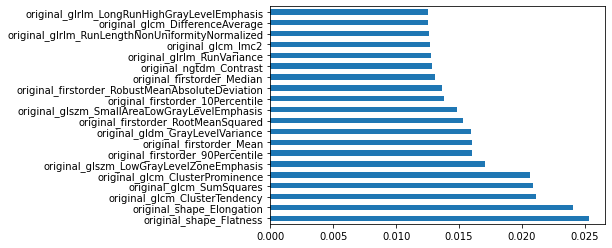

In [31]:

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
print(feat_importances.nlargest(20))
plt.show()

original_glcm_Imc1                                    0.266406
original_glrlm_RunPercentage                          0.187265
original_shape_SurfaceVolumeRatio                     0.180369
original_glrlm_ShortRunEmphasis                       0.173734
original_glrlm_RunLengthNonUniformityNormalized       0.154432
original_gldm_SmallDependenceEmphasis                 0.118801
original_glszm_HighGrayLevelZoneEmphasis              0.117352
original_glcm_DifferenceEntropy                       0.108755
original_ngtdm_Coarseness                             0.106534
original_ngtdm_Strength                               0.095479
original_glszm_ZonePercentage                         0.087130
original_gldm_SmallDependenceLowGrayLevelEmphasis     0.086642
original_glcm_DifferenceAverage                       0.085261
original_glrlm_GrayLevelNonUniformityNormalized       0.081450
original_gldm_DependenceNonUniformityNormalized       0.080230
original_gldm_SmallDependenceHighGrayLevelEmphasis    0

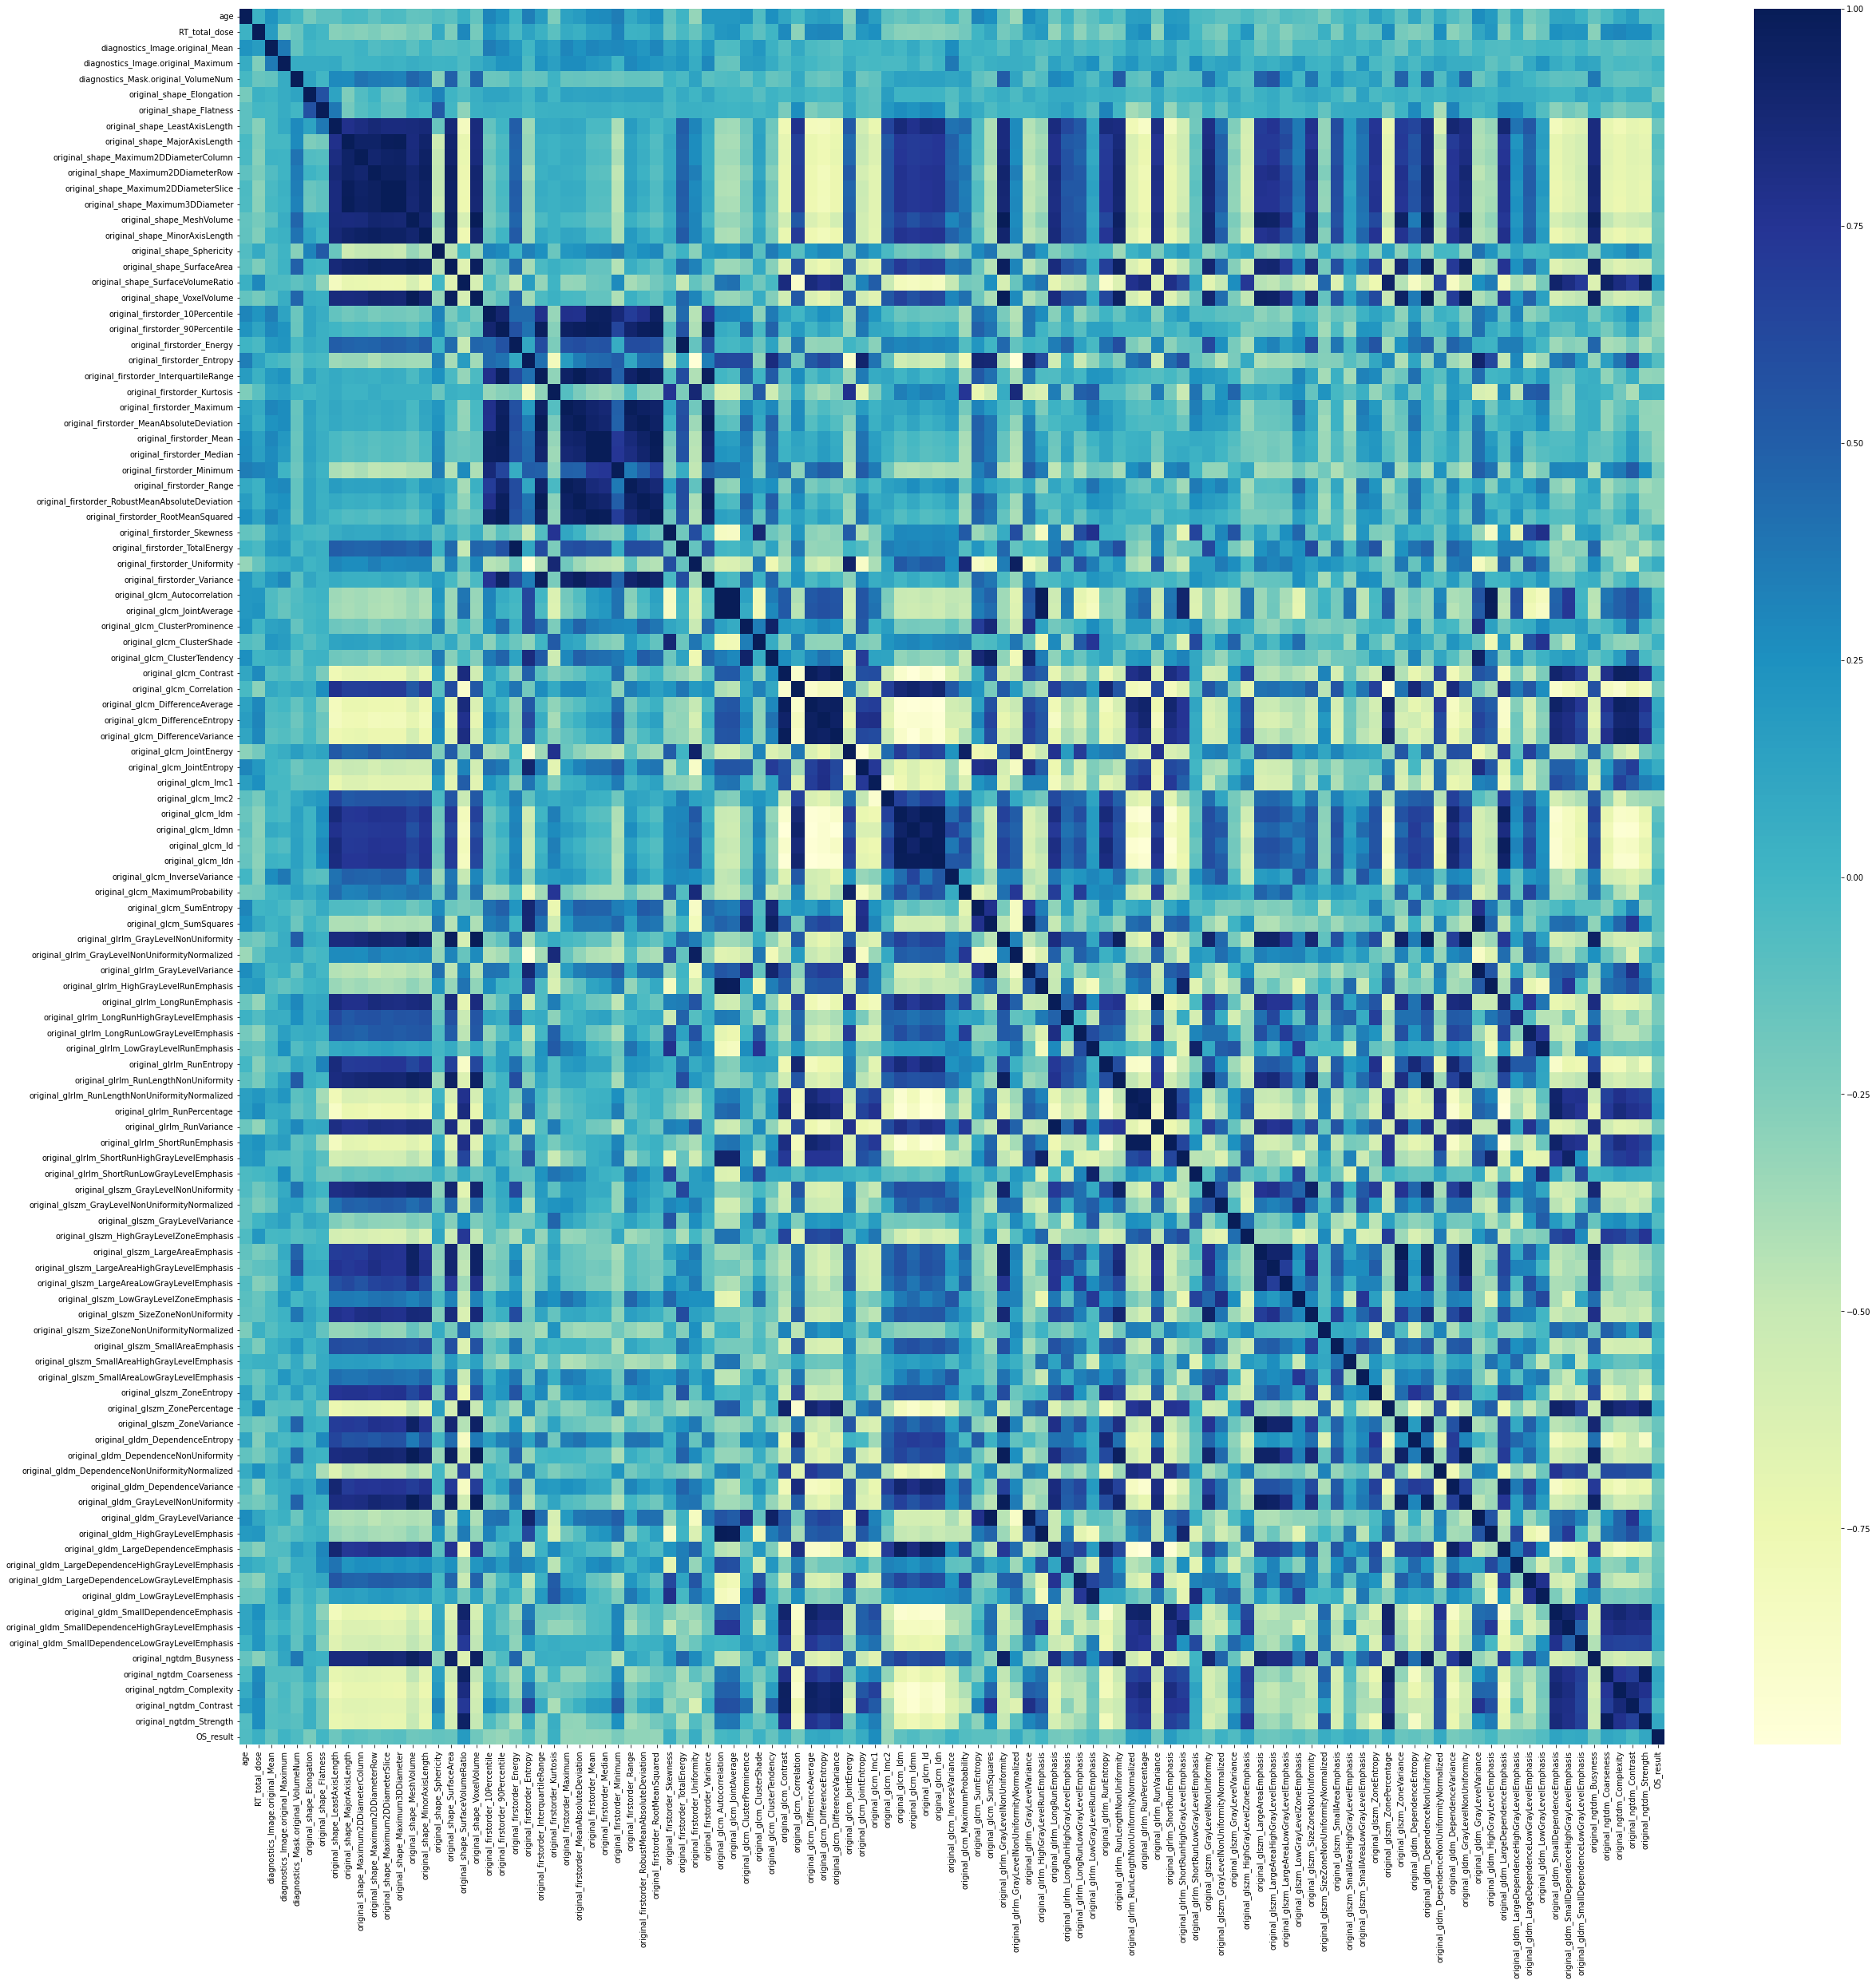

In [25]:
corrmat = radiomic_features_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(40,40))
#plot heat map
g=sns.heatmap(radiomic_features_df[top_corr_features].corr(),cmap="YlGnBu")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(radiomic_features_df[top_corr_features].corr()['OS_result'][:-1].sort_values(ascending=False))


0.7314285714285714 {'criterion': 'gini', 'random_state': 18}


c:\Users\Pc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


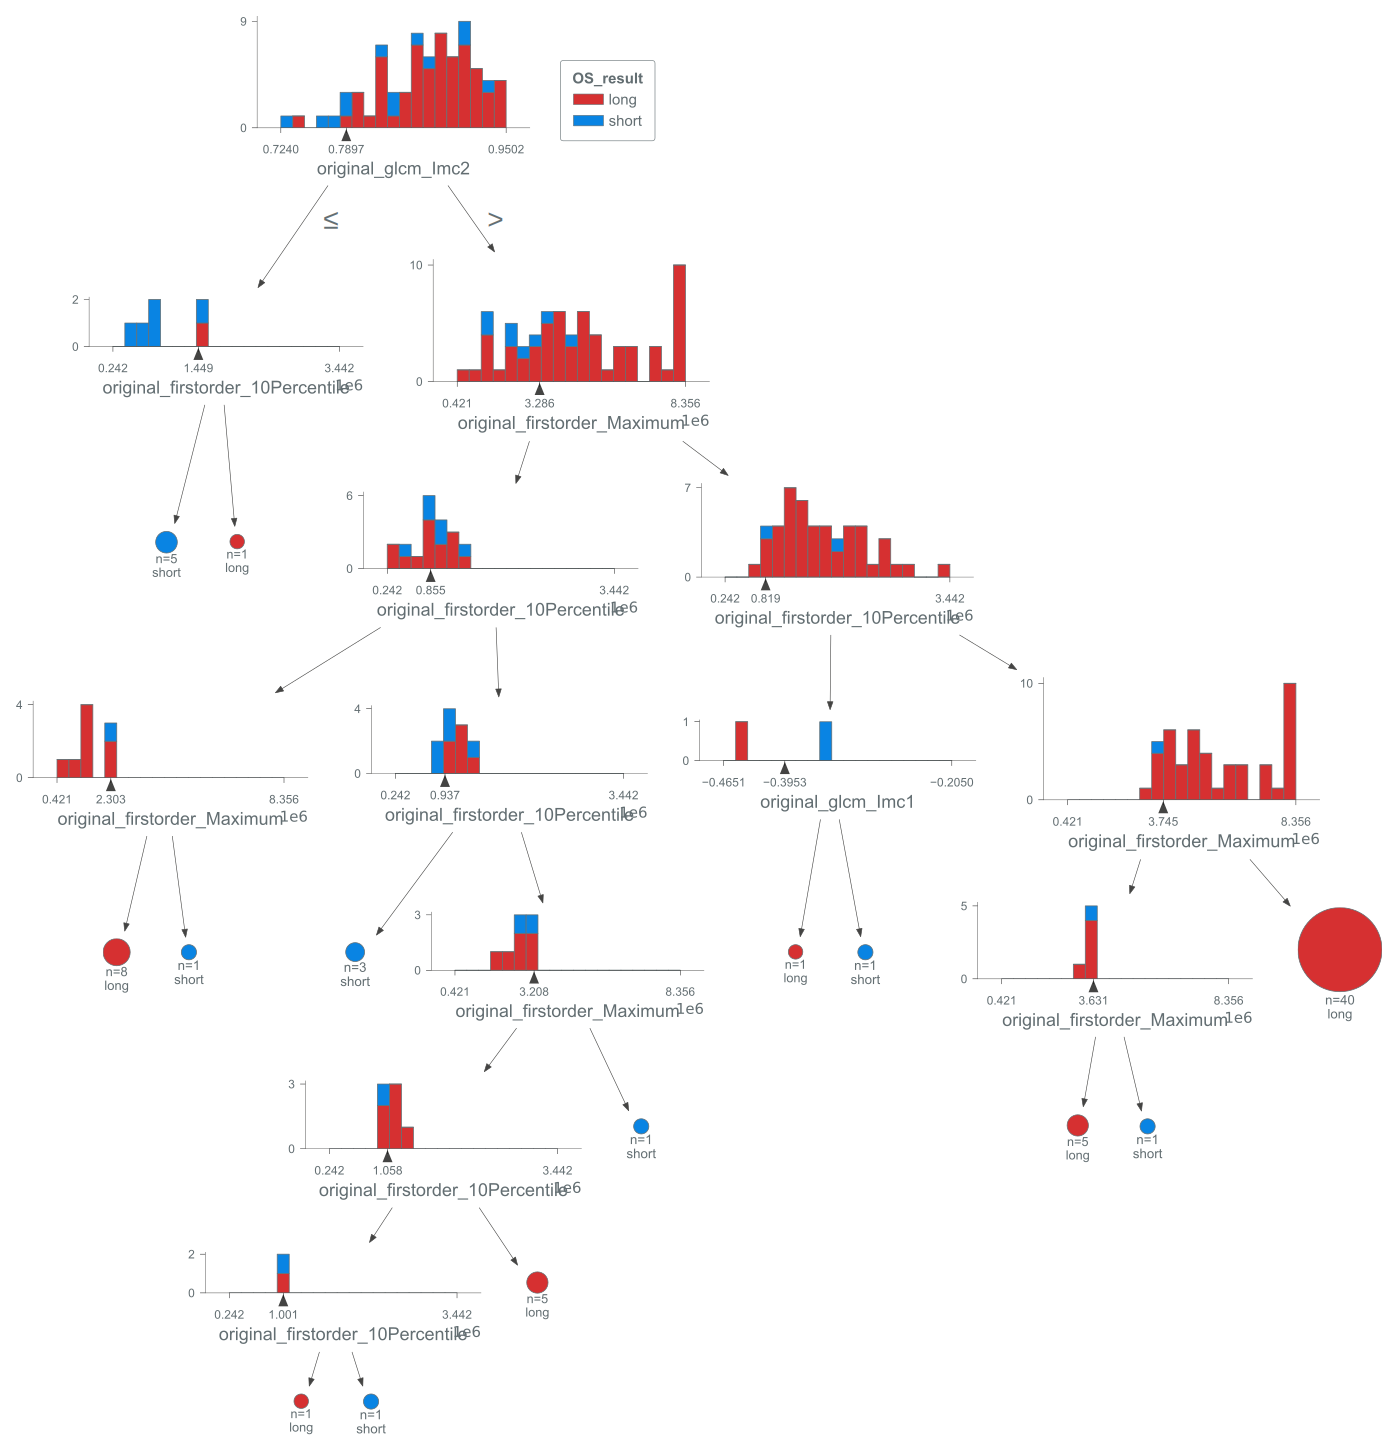

In [8]:
classes = ["original_glcm_Imc2", "original_glcm_Imc1", "original_firstorder_10Percentile", "original_firstorder_Mean", "original_firstorder_Maximum"]
X = radiomic_features_df[classes]
y = radiomic_features_df.OS_result
cv = KFold(n_splits=5, random_state=1, shuffle=True)
tree_class = DecisionTreeClassifier()
parameters = {    
    'criterion' :['gini', 'entropy'],
    'random_state' : [18]}
clf = GridSearchCV(tree_class, parameters, cv = 5)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 
viz = dtreeviz.model(tree_model, X, y,
                target_name="OS_result",
                feature_names=classes,
                class_names=["long", "short"])
viz.view(
    colors={'classes': [
    None,  # 0 classes
    None,  # 1 class
    ['#d63031', '#0984e3'],  # 2 classes
],

              'split_line': '#636e72',
              'axis_label': '#636e72',
              'title': '#636e72',
              'legend_title': '#636e72',
              'legend_edge': '#636e72',
              'edge': '#636e72',
              'rect_edge': '#636e72',
              'text': '#636e72',
              'arrow': '#636e72',
              'node_label': '#636e72',
              'tick_label': '#636e72',
              'leaf_label': '#636e72',
              'pie': '#636e72',
},
    fancy=True,
    scale=2)

0.7857142857142858 {'criterion': 'entropy', 'random_state': 18}


c:\Users\Pc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


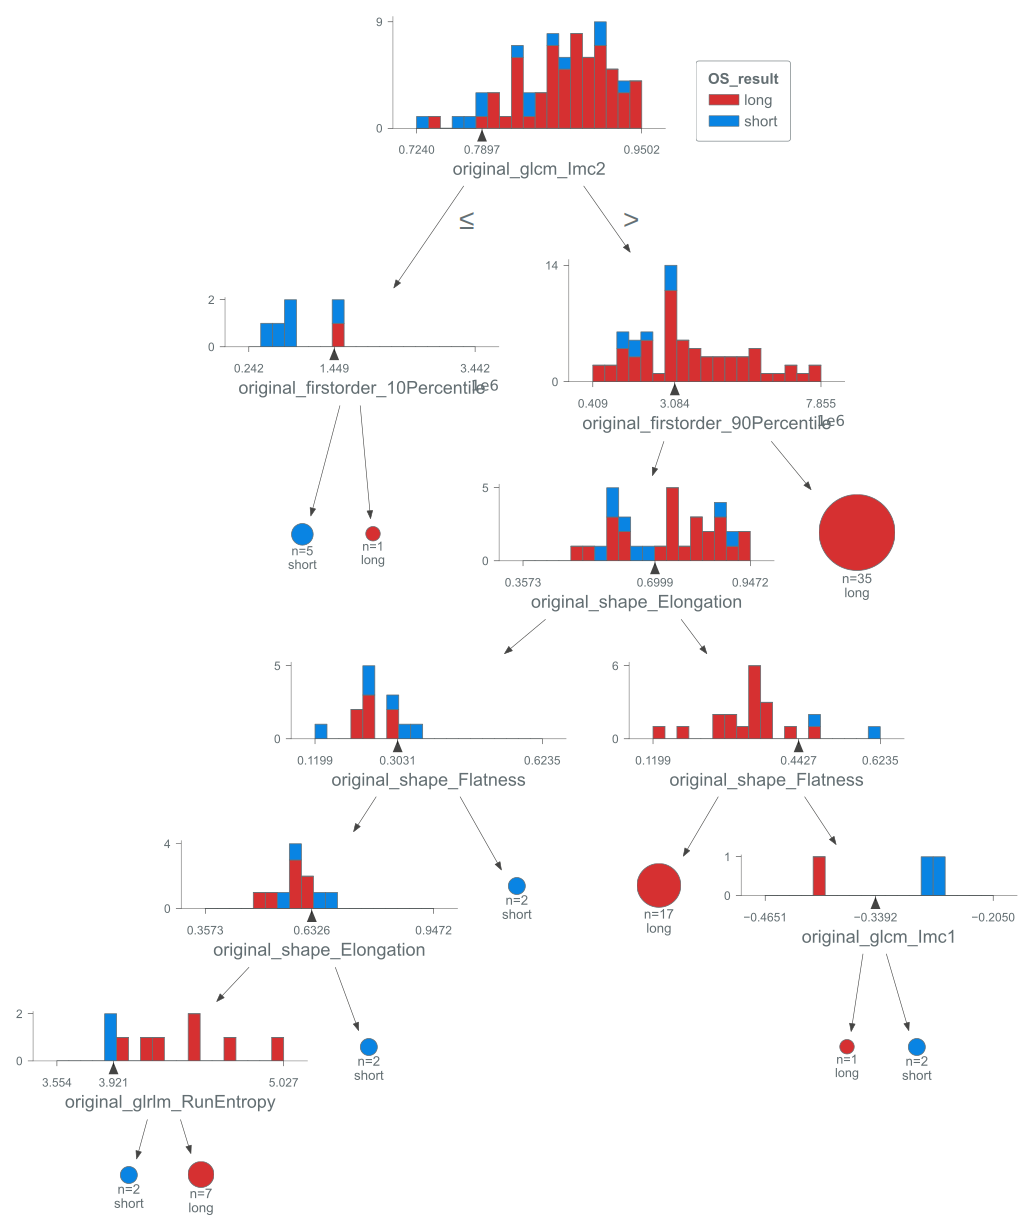

In [20]:
classes = ["original_glcm_Imc2", "original_glcm_Imc1", "original_firstorder_10Percentile", "original_firstorder_Mean", "original_firstorder_Maximum", 
           "original_firstorder_90Percentile", "original_shape_Flatness", "original_shape_Elongation","original_glrlm_RunEntropy" , "original_firstorder_InterquartileRange"]
X = radiomic_features_df[classes]
y = radiomic_features_df.OS_result
cv = KFold(n_splits=5, random_state=1, shuffle=True)
tree_class = DecisionTreeClassifier()
parameters = {    
    'criterion' :['gini', 'entropy'],
    'random_state' : [18]}
clf = GridSearchCV(tree_class, parameters, cv = 5)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 
viz = dtreeviz.model(tree_model, X, y,
                target_name="OS_result",
                feature_names=classes,
                class_names=["long", "short"])
viz.view(
    colors={'classes': [
    None,  # 0 classes
    None,  # 1 class
    ['#d63031', '#0984e3'],  # 2 classes
],

              'split_line': '#636e72',
              'axis_label': '#636e72',
              'title': '#636e72',
              'legend_title': '#636e72',
              'legend_edge': '#636e72',
              'edge': '#636e72',
              'rect_edge': '#636e72',
              'text': '#636e72',
              'arrow': '#636e72',
              'node_label': '#636e72',
              'tick_label': '#636e72',
              'leaf_label': '#636e72',
              'pie': '#636e72',
},
    fancy=True,
    scale=2)

0.799047619047619 {'criterion': 'entropy', 'random_state': 18}


c:\Users\Pc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


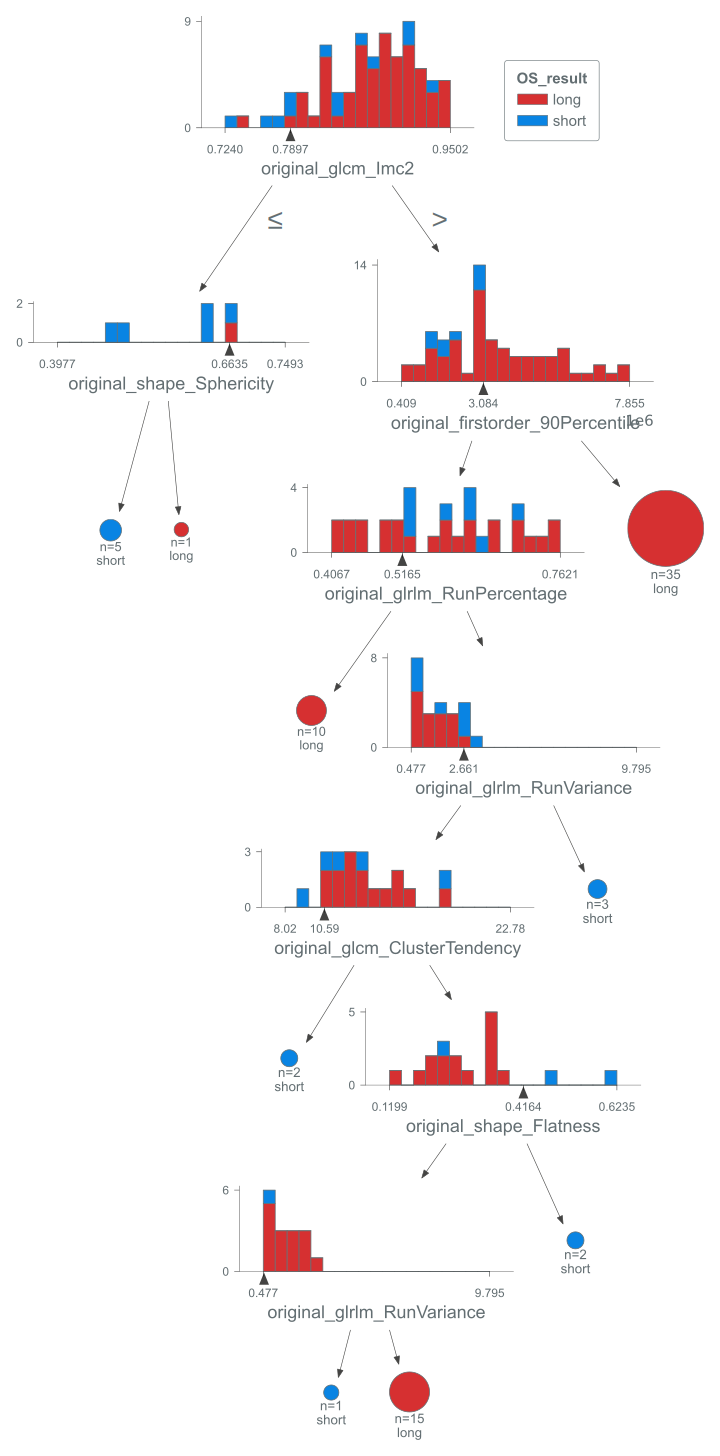

In [41]:
classes = ["original_glcm_Imc2", "original_glcm_Imc1", "original_firstorder_10Percentile", "original_firstorder_Mean", "original_firstorder_Maximum", 
           "original_firstorder_90Percentile", "original_shape_Flatness", "original_shape_Elongation","original_glrlm_RunEntropy" , "original_firstorder_InterquartileRange",
           "original_firstorder_RootMeanSquared", "original_glcm_ClusterTendency", "original_shape_Sphericity", "original_glrlm_RunVariance", "original_glrlm_RunPercentage" ]
X = radiomic_features_df[classes]
y = radiomic_features_df.OS_result
cv = KFold(n_splits=5, random_state=1, shuffle=True)
tree_class = DecisionTreeClassifier()
parameters = {    
    'criterion' :['gini', 'entropy'],
    'random_state' : [18]}
clf = GridSearchCV(tree_class, parameters, cv = 5)
clf.fit(X=X, y=y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 
viz = dtreeviz.model(tree_model, X, y,
                target_name="OS_result",
                feature_names=classes,
                class_names=["long", "short"])
viz.view(
    colors={'classes': [
    None,  # 0 classes
    None,  # 1 class
    ['#d63031', '#0984e3'],  # 2 classes
],

              'split_line': '#636e72',
              'axis_label': '#636e72',
              'title': '#636e72',
              'legend_title': '#636e72',
              'legend_edge': '#636e72',
              'edge': '#636e72',
              'rect_edge': '#636e72',
              'text': '#636e72',
              'arrow': '#636e72',
              'node_label': '#636e72',
              'tick_label': '#636e72',
              'leaf_label': '#636e72',
              'pie': '#636e72',
},
    fancy=True,
    scale=2)